In [27]:
import geopandas
import pandas
import dask_geopandas
import momepy
import seaborn
import pygeos
import pandas
import numpy
from dask.distributed import Client, LocalCluster
import matplotlib.pyplot as plt


In [2]:
client = Client(LocalCluster(n_workers=16))
client

Client Scheduler: tcp://127.0.0.1:43365 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 16 Cores: 16 Memory: 134.91 GB


In [3]:
pygeos.__version__

'0.9'

In [10]:
signatures = dask_geopandas.from_geopandas(geopandas.read_parquet("../../urbangrammar_samba/spatial_signatures/signatures/signatures_combined_levels_orig.pq"), npartitions=32)

In [11]:
signatures

,kmeans10gb,geometry,level2,signature_type
npartitions=32,,,,
0,int64,geometry,float64,object
3022,...,...,...,...
...,...,...,...,...
93682,...,...,...,...
96703,...,...,...,...


In [12]:
signatures["area"] = signatures.area
signatures["perimeter"] = signatures.length
signatures["eri"] = signatures.map_partitions(lambda p: momepy.EquivalentRectangularIndex(p).series, meta=pandas.Series(dtype="float"))
signatures["circular_compactness"] = signatures.map_partitions(lambda p: momepy.CircularCompactness(p).series, meta=pandas.Series(dtype="float"))
signatures["donut_index"] = signatures.map_partitions(lambda p: momepy.CourtyardIndex(p, momepy.CourtyardArea(p).series).series, meta=pandas.Series(dtype="float"))
signatures["fractality"] = signatures.map_partitions(lambda p: momepy.FractalDimension(p).series, meta=pandas.Series(dtype="float"))
signatures["convexity"] = signatures.map_partitions(lambda p: momepy.Convexity(p).series, meta=pandas.Series(dtype="float"))

In [13]:
%%time
signatures = signatures.compute()

CPU times: user 12.8 s, sys: 5.15 s, total: 17.9 s
Wall time: 32.1 s


In [15]:
signatures.drop(columns=["kmeans10gb", "geometry", "level2"]).to_parquet("../../urbangrammar_samba/spatial_signatures/esda/sizeshape.pq")

<ipython-input-15-9c695be00e9b>:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  signatures.drop(columns=["kmeans10gb", "geometry", "level2"]).to_parquet("../../urbangrammar_samba/spatial_signatures/esda/sizeshape.pq")


In [34]:
signatures.drop(columns=["kmeans10gb", "geometry", "level2"]).to_csv("../../urbangrammar_samba/spatial_signatures/esda/sizeshape.csv")

In [16]:
signatures

,kmeans10gb,geometry,level2,signature_type,area,perimeter,eri,circular_compactness,donut_index,fractality,convexity
0,0,"POLYGON Z ((62220.000 798500.000 0.000, 62110....",0.0,0_0,1.826984e+07,29577.575163,0.601828,0.439852,0.000071,1.065559,0.788857
1,0,"POLYGON Z ((63507.682 796515.169 0.000, 63471....",0.0,0_0,1.235908e+04,555.207264,0.892662,0.254347,0.000000,1.047118,0.983245
2,0,"POLYGON Z ((65953.174 802246.172 0.000, 65950....",0.0,0_0,7.234542e+05,5746.792461,0.602136,0.339522,0.000000,1.077707,0.629428
3,0,"POLYGON Z ((67297.740 803435.800 0.000, 67220....",0.0,0_0,1.229467e+06,6161.670240,0.731125,0.306803,0.000000,1.046892,0.799648
4,0,"POLYGON Z ((75760.000 852670.000 0.000, 75700....",0.0,0_0,7.604014e+06,22500.262066,0.539593,0.252670,0.000281,1.089988,0.641429
...,...,...,...,...,...,...,...,...,...,...,...
96699,9,"POLYGON ((323321.005 463795.416, 323319.842 46...",8.0,9_8,4.070783e+04,824.963123,1.020075,0.453320,0.000000,1.004137,0.999224
96700,9,"POLYGON ((325929.840 1008792.061, 325927.377 1...",8.0,9_8,3.523702e+03,270.956057,0.959089,0.334764,0.000000,1.032331,0.995177
96701,9,"POLYGON ((337804.770 1013422.583, 337800.122 1...",8.0,9_8,1.236944e+05,1525.262336,1.017609,0.370246,0.000000,1.013789,0.965269
96702,9,"POLYGON ((422304.270 1147826.990, 422296.000 1...",8.0,9_8,1.526104e+03,189.735084,0.954954,0.277671,0.000000,1.052956,0.921173


In [21]:
outliers = ["9_8", "9_3", "9_6", "9_7"]
signatures = signatures[~signatures.signature_type.isin(outliers)]

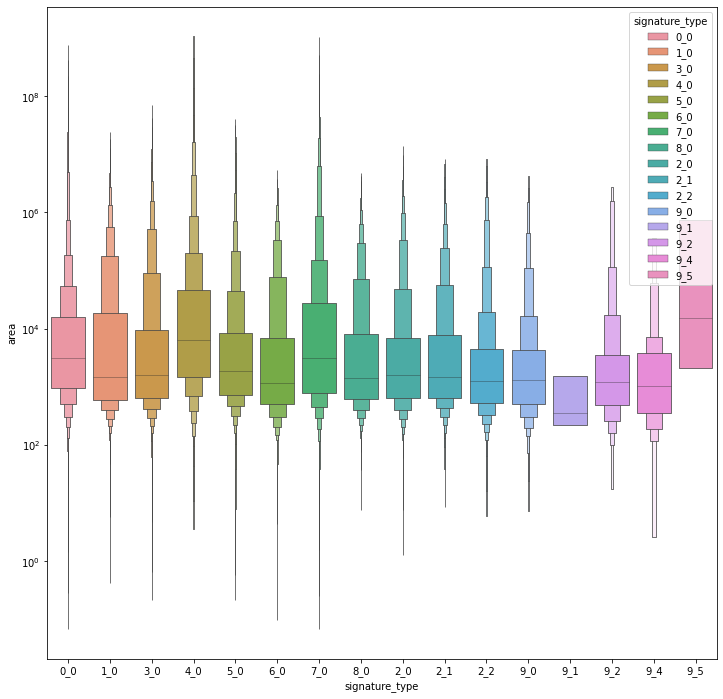

In [24]:

fig, ax = plt.subplots(figsize=(12, 12))
seaborn.boxenplot(x="signature_type", y='area', hue='signature_type', dodge=False, data=signatures, ax=ax, showfliers=False, linewidth=.75)
ax.set_yscale("log")

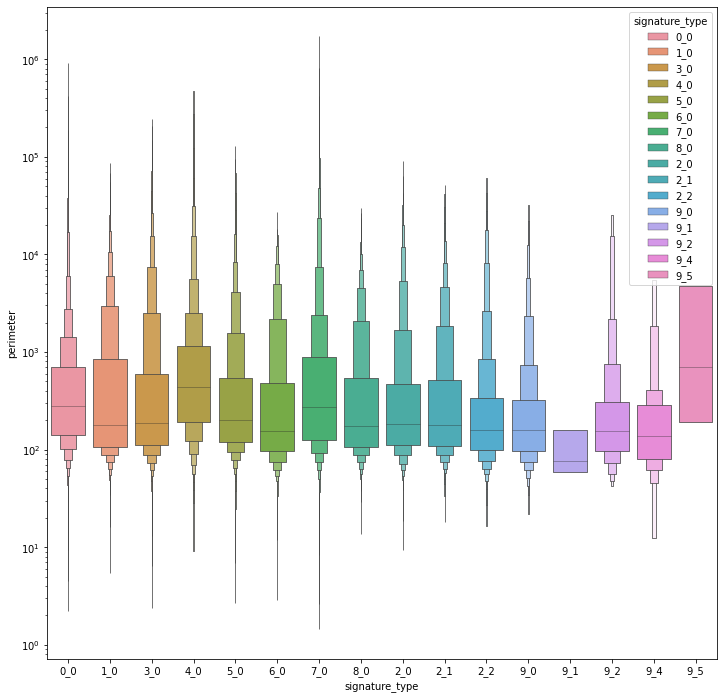

In [25]:
fig, ax = plt.subplots(figsize=(12, 12))
seaborn.boxenplot(x="signature_type", y='perimeter', hue='signature_type', dodge=False, data=signatures, ax=ax, showfliers=False, linewidth=.75)
ax.set_yscale("log")

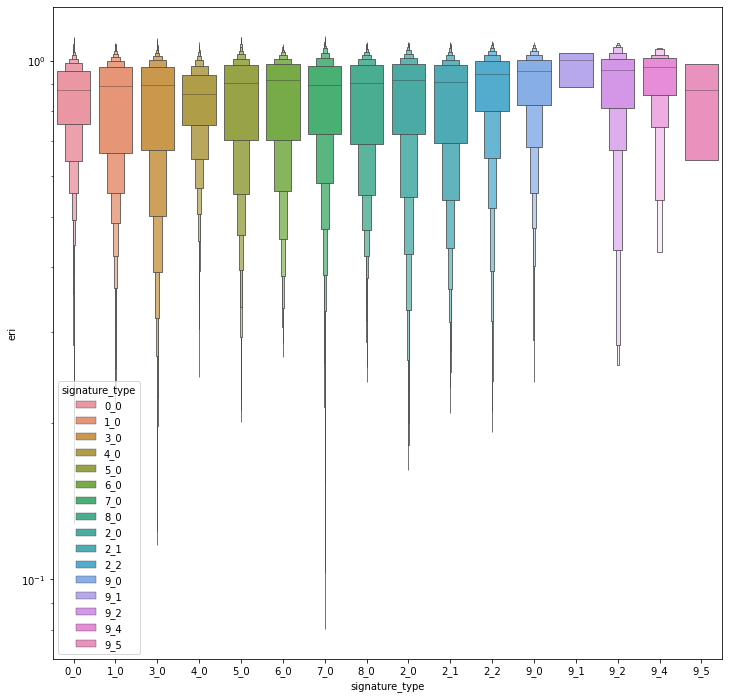

In [26]:
fig, ax = plt.subplots(figsize=(12, 12))
seaborn.boxenplot(x="signature_type", y='eri', hue='signature_type', dodge=False, data=signatures, ax=ax, showfliers=False, linewidth=.75)
ax.set_yscale("log")

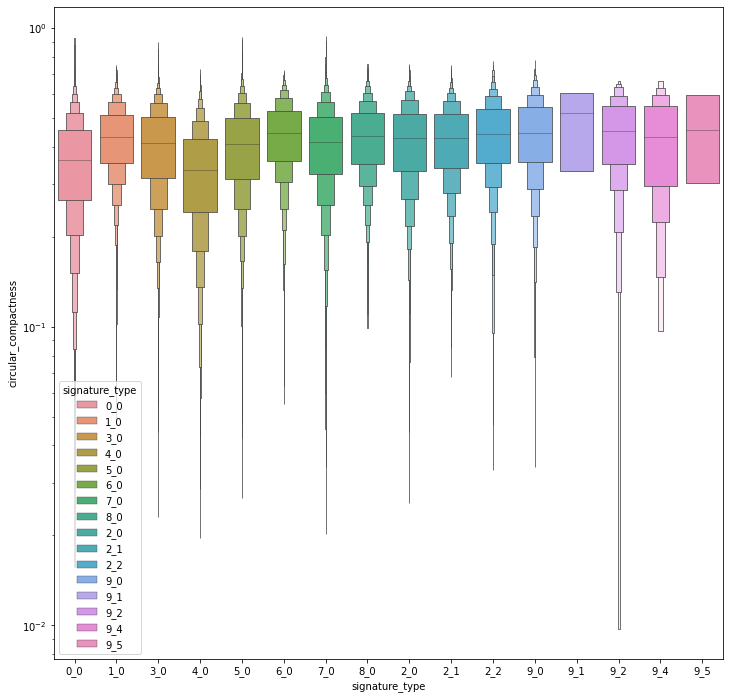

In [27]:
fig, ax = plt.subplots(figsize=(12, 12))
seaborn.boxenplot(x="signature_type", y='circular_compactness', hue='signature_type', dodge=False, data=signatures, ax=ax, showfliers=False, linewidth=.75)
ax.set_yscale("log")

<AxesSubplot:xlabel='signature_type', ylabel='donut_index'>

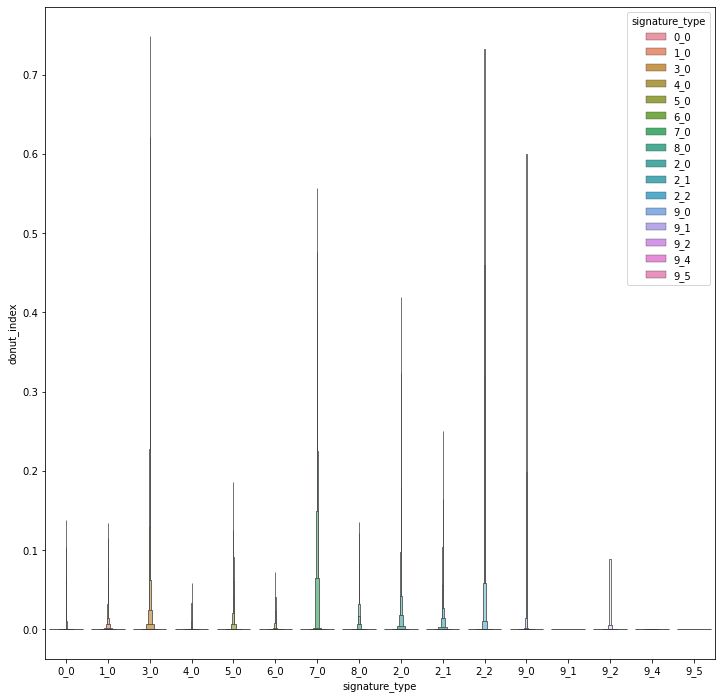

In [29]:
fig, ax = plt.subplots(figsize=(12, 12))
seaborn.boxenplot(x="signature_type", y='donut_index', hue='signature_type', dodge=False, data=signatures, ax=ax, showfliers=False, linewidth=.75)
# ax.set_yscale("log")

<AxesSubplot:xlabel='signature_type', ylabel='fractality'>

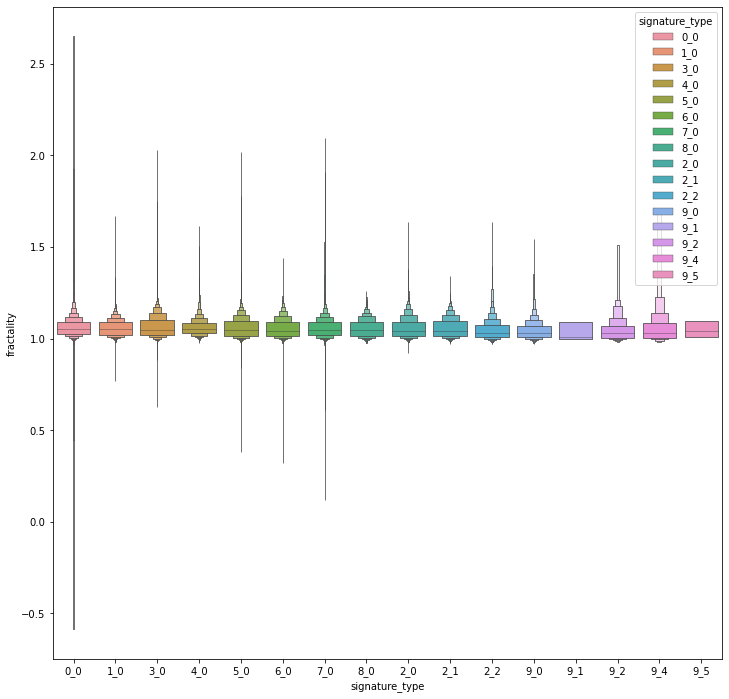

In [32]:
fig, ax = plt.subplots(figsize=(12, 12))
seaborn.boxenplot(x="signature_type", y='fractality', hue='signature_type', dodge=False, data=signatures, ax=ax, showfliers=False, linewidth=.75)
# ax.set_yscale("log")

<AxesSubplot:xlabel='signature_type', ylabel='convexity'>

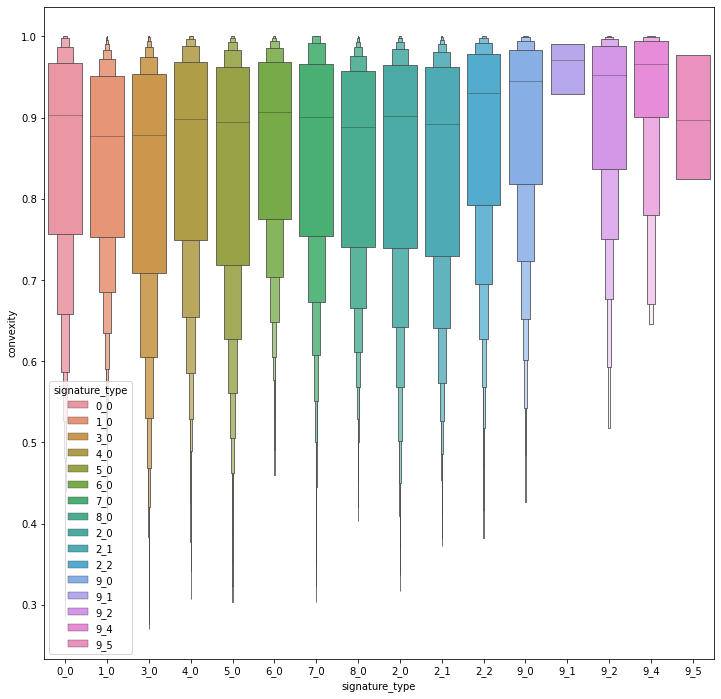

In [33]:
fig, ax = plt.subplots(figsize=(12, 12))
seaborn.boxenplot(x="signature_type", y='convexity', hue='signature_type', dodge=False, data=signatures, ax=ax, showfliers=False, linewidth=.75)
# ax.set_yscale("log")

<AxesSubplot:xlabel='signature_type'>

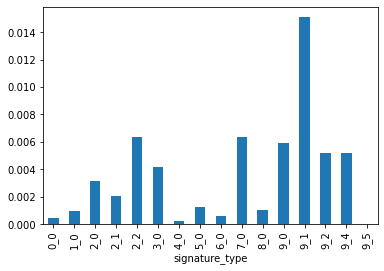

In [41]:
signatures.groupby('signature_type').mean().donut_index.plot.bar()

In [38]:
mask = pandas.Series(numpy.zeros(len(signatures), dtype=bool), index=signatures.index)
mask

0        False
1        False
2        False
3        False
4        False
         ...  
96687    False
96688    False
96689    False
96690    False
96691    False
Length: 96689, dtype: bool

In [39]:
for cl in signatures.signature_type.unique():
    sub = signatures[signatures.signature_type == cl]
    mean = sub.area.mean()
    above = sub.area > mean
    mask[above[above].index] = True

In [41]:
mask.sum()

6915

In [42]:
significant = signatures[mask]

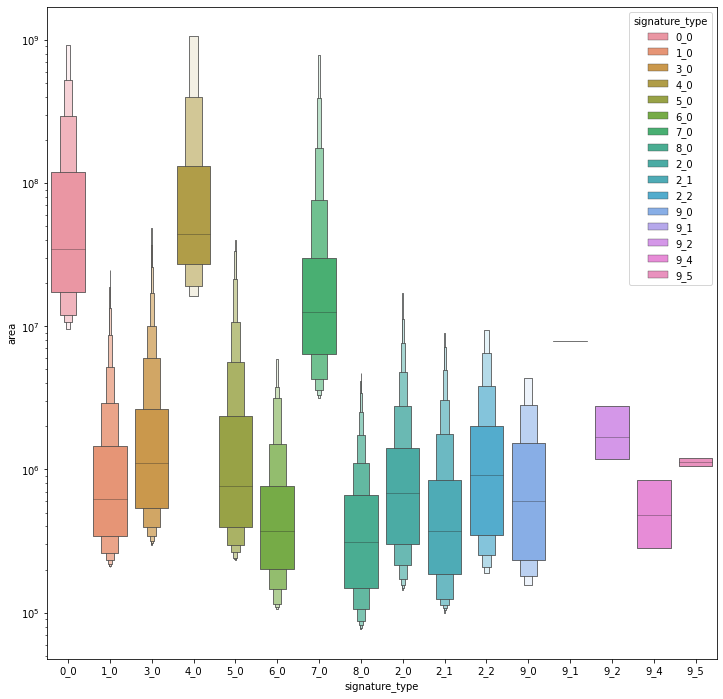

In [43]:
fig, ax = plt.subplots(figsize=(12, 12))
seaborn.boxenplot(x="signature_type", y='area', hue='signature_type', dodge=False, data=significant, ax=ax, showfliers=False, linewidth=.75)
ax.set_yscale("log")

<AxesSubplot:xlabel='signature_type', ylabel='eri'>

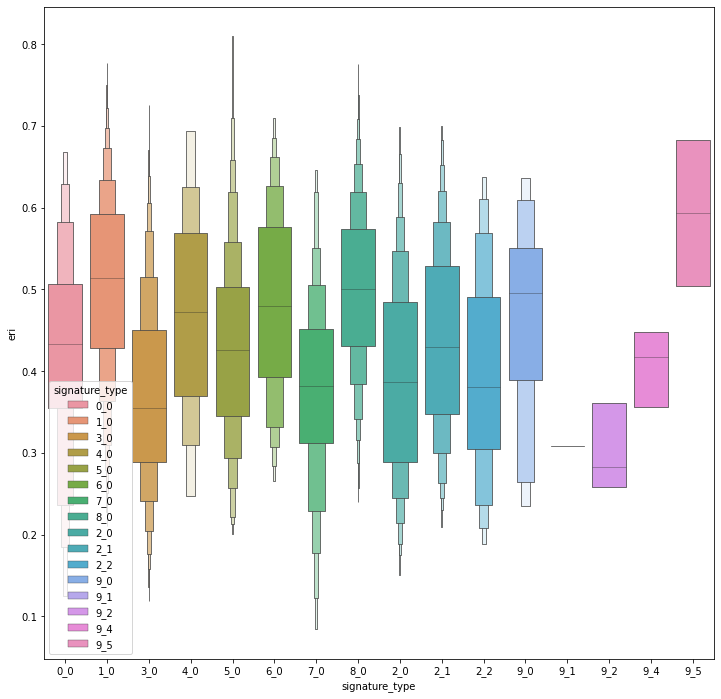

In [46]:
fig, ax = plt.subplots(figsize=(12, 12))
seaborn.boxenplot(x="signature_type", y='eri', hue='signature_type', dodge=False, data=significant, ax=ax, showfliers=False, linewidth=.75)
# ax.set_yscale("log")

<AxesSubplot:xlabel='signature_type', ylabel='circular_compactness'>

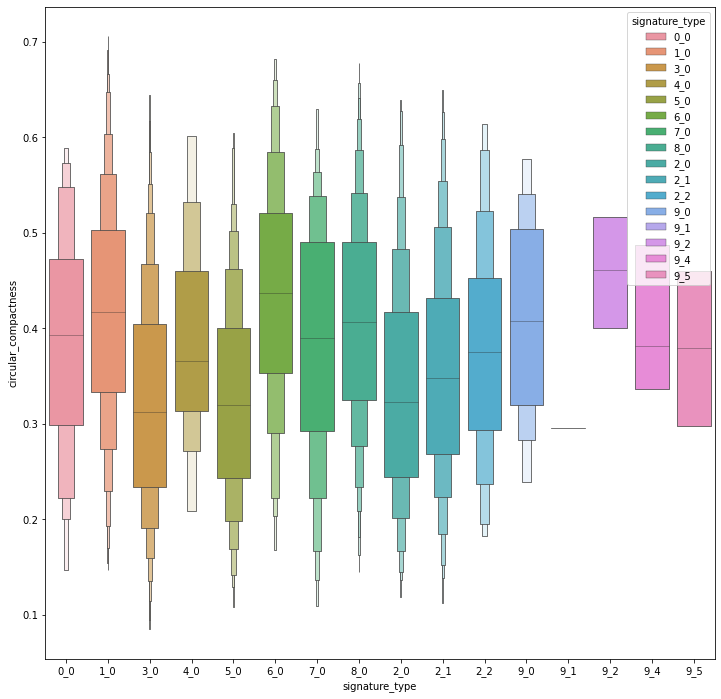

In [47]:
fig, ax = plt.subplots(figsize=(12, 12))
seaborn.boxenplot(x="signature_type", y='circular_compactness', hue='signature_type', dodge=False, data=significant, ax=ax, showfliers=False, linewidth=.75)
# ax.set_yscale("log")

<AxesSubplot:xlabel='signature_type', ylabel='donut_index'>

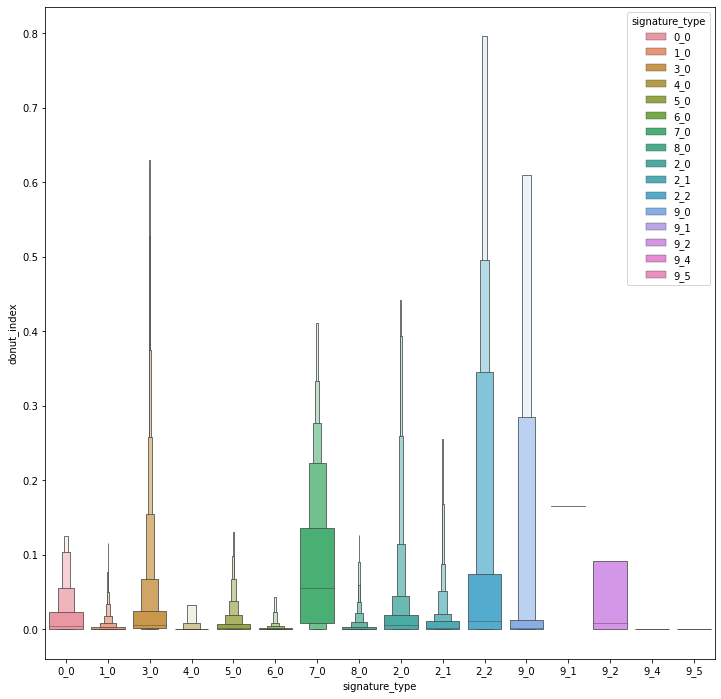

In [48]:
fig, ax = plt.subplots(figsize=(12, 12))
seaborn.boxenplot(x="signature_type", y='donut_index', hue='signature_type', dodge=False, data=significant, ax=ax, showfliers=False, linewidth=.75)
# ax.set_yscale("log")

<AxesSubplot:xlabel='signature_type', ylabel='convexity'>

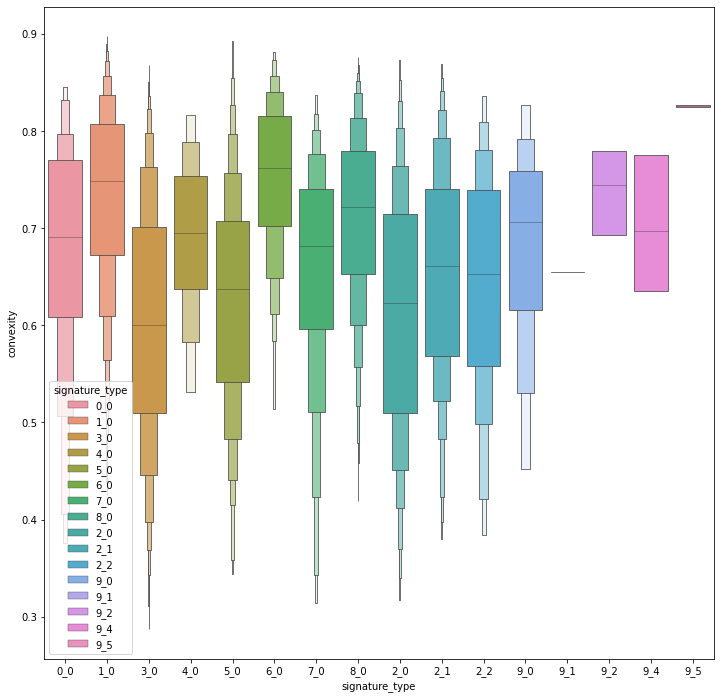

In [49]:
fig, ax = plt.subplots(figsize=(12, 12))
seaborn.boxenplot(x="signature_type", y='convexity', hue='signature_type', dodge=False, data=significant, ax=ax, showfliers=False, linewidth=.75)
# ax.set_yscale("log")